# MDA project: predicting crowdedness in Leuven through noise and weather data

### Importing packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold



### Loading data and adding time-related features

In [49]:
final_df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
final_df['result_timestamp'] = pd.to_datetime(final_df['result_timestamp'], format='%Y-%m-%d %H:%M:%S')

Perform 80-20 split

In [50]:
#create noise df from first 80%
def split8020(df):
    first80 = int(len(df) * 0.8)
    last20 = int(len(df) * 0.2)
    df_first80 = df.iloc[:first80,]
    df_last20 = df.iloc[last20:,]

    return df_first80, df_last20

final_df_first80, final_df_last20 = split8020(final_df)

In [51]:
final_df_first80.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265964 entries, 0 to 265963
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   object_id         265964 non-null  int64         
 1   result_timestamp  265964 non-null  datetime64[ns]
 2   laeq              265964 non-null  float64       
 3   hour              265964 non-null  int64         
 4   day_of_week       265964 non-null  int64         
 5   month             265964 non-null  int64         
 6   weekend           265964 non-null  bool          
 7   holiday           265964 non-null  bool          
 8   exam_period       265964 non-null  bool          
 9   key               265964 non-null  object        
 10  255439            265964 non-null  bool          
 11  255440            265964 non-null  bool          
 12  255441            265964 non-null  bool          
 13  255442            265964 non-null  bool          
 14  2554

### Exploratory data analyses

In [52]:
#Select only 3 locations close to Oude Markt
final_df_first80 = final_df_first80[final_df_first80['object_id']<255442]
final_df_last20 = final_df_last20[final_df_last20['object_id']<255442]

In [53]:
final_df_first80

,object_id,result_timestamp,laeq,hour,day_of_week,month,weekend,holiday,exam_period,key,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,255441,2022-01-01 00:00:00,63.267554,0,5,1,True,True,False,2554412022-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,255441,2022-01-01 00:10:00,60.254000,0,5,1,True,True,False,2554412022-01-01 00:10:00,...,0.0,0.0,0.0,-48.0,0.04,0.0,13.28,13.28,13.223,13.23639
8,255441,2022-01-01 00:20:00,55.143907,0,5,1,True,True,False,2554412022-01-01 00:20:00,...,0.0,0.0,0.0,45.0,0.02,0.0,13.28,13.28,13.223,13.16699
12,255441,2022-01-01 00:30:00,58.230167,0,5,1,True,True,False,2554412022-01-01 00:30:00,...,0.0,0.0,0.0,-52.0,0.04,0.0,13.28,13.28,13.223,13.19886
16,255441,2022-01-01 00:40:00,54.220466,0,5,1,True,True,False,2554412022-01-01 00:40:00,...,0.0,0.0,0.0,34.0,0.02,0.0,13.28,13.28,13.223,13.16699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265935,255441,2022-10-27 19:10:00,57.141000,19,3,10,False,False,False,2554412022-10-27 19:10:00,...,0.0,0.0,0.0,-174.0,0.01,0.0,19.33,19.33,19.273,19.25221
265941,255441,2022-10-27 19:20:00,57.161000,19,3,10,False,False,False,2554412022-10-27 19:20:00,...,0.0,0.0,0.0,-93.0,0.02,0.0,19.39,19.39,19.333,19.30490
265947,255441,2022-10-27 19:30:00,57.954500,19,3,10,False,False,False,2554412022-10-27 19:30:00,...,0.0,0.0,0.0,-112.0,0.13,0.0,19.31,19.31,19.253,19.26722
265953,255441,2022-10-27 19:40:00,57.600333,19,3,10,False,False,False,2554412022-10-27 19:40:00,...,0.0,0.0,0.0,-86.0,0.04,0.0,19.38,19.38,19.323,19.28698


Preprocessing pipeline: delaying noise and weather

In [54]:
#pipeline to create feature matrix with delayed noise and weather data, as well as target vector.

def delay_noise_weather(df):
    # Select columns for df_noisedelay
    df_noisedelay = df.loc[:, ['object_id', 'result_timestamp', 'laeq']]
    df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
    df_noisedelay= df_noisedelay.drop('laeq',axis=1)
    
    # Add 6 hours to result_timestamp
    df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_noisedelay = df_noisedelay.drop(['object_id', 'result_timestamp'], axis=1)

    # Select columns for df_weatherdelay
    df_weatherdelay = df.loc[:, ['object_id', 'result_timestamp', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                          'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]

    # Add 6 hours to result_timestamp
    df_weatherdelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_weatherdelay['key'] = df_weatherdelay['object_id'].astype(str) + df_weatherdelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_weatherdelay = df_weatherdelay.drop(['object_id', 'result_timestamp'], axis=1)

    #Drop weather-related columns from original df
    df = df.drop(['LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                  'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0'], axis=1)
    df['key'] = df['object_id'].astype(str) + df['result_timestamp'].astype(str)

    # Merge df with df_noisedelay and df_weatherdelay on 'key'
    delayed_df = pd.merge(df, df_noisedelay, on='key').merge(df_weatherdelay, on='key')

    # Delete observations with missing values
    delayed_df = delayed_df.dropna()

    # Create feature matrix X and target vector y
    X = delayed_df.drop(['result_timestamp', 'key','laeq', 'object_id','255442', '255443', '255444', '255445',
       '280324', '303910'], axis=1)
    y = delayed_df['laeq']

    # Return full dataframe with delays, return feature matrix X and target vector y
    return delayed_df, X, y

#Apply to df
delayed_df, X, y = delay_noise_weather(final_df_first80)
    

### Pipelines to fit all models (with cross-validation and hyperparameter tuning)

Create pipeline for Ridge with spline transformations

In [55]:

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )
#creating spline transformers
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

#creating interactions
hour_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

day_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

hour_weekend_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("weekend", FunctionTransformer(lambda x: x == 1), ["weekend"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

#adding combining the spline pipeline and the interactions pipeline
Ridge_splines = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions1", hour_weekend_interaction),
            ("interactions2",day_holiday_interaction ),
            ("interactions3",hour_holiday_interaction),
            
        ]
    ),
    Ridge(),
)

5-fold cross validation object

In [56]:
cv = KFold(n_splits=5, shuffle=True)

Evaluate different models and select best performing model

In [60]:
def evaluate_models(X, y, cv, models):
    best_model = None
    best_rmse = float('inf')

    for model in models:
        if isinstance(model, XGBRegressor):
            # Parameter grid for XGBoost model
            param_grid = {
                'learning_rate': [0.05, 0.06,0.07,0.08],
                'n_estimators': [100, 110,120,130],
                'max_depth': [5, 6,7,8]
            }
        elif isinstance(model, HistGradientBoostingRegressor):
            # Parameter grid for HistGradientBoostingRegressor model
            param_grid = {
                'learning_rate': [0.05, 0.06,0.07,0.08],
                'max_leaf_nodes': [9, 10,11,12]
            }
        elif isinstance(model, Pipeline) and isinstance(model.steps[-1][1], Ridge):
            # Parameter grid for Ridge model with splines 
            param_grid = {
                "ridge__alpha": np.logspace(-6, 6, 25)
            }
        else:
            # Use default hyperparameters for other models
            best_model = model
            print(f"Using default hyperparameters for model: {type(model).__name__}")
            continue

        # Define custom scorer using mean squared error
        scorer = 'neg_mean_squared_error'

        # Perform grid search with time series cross-validation
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scorer)
        grid_search.fit(X, y)

        # Get the best parameters and score from the search
        best_params = grid_search.best_params_
        score = -grid_search.best_score_
        print(f"Results of Grid Search for model: {type(model).__name__}")
        print(f"Best Parameters: {best_params}")
        print(f"Best Score: {score}")

        # Evaluate each model using time series cross-validation
        cv_results = cross_validate(
            model.set_params(**best_params),
            X,
            y,
            cv=cv,
            scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        )
        mae = -cv_results["test_neg_mean_absolute_error"]
        rmse = -cv_results["test_neg_root_mean_squared_error"]
        print(
            f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
            f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
        )

        if np.mean(rmse) < best_rmse:
            best_model = model.set_params(**best_params)
            best_rmse = np.mean(rmse)

    return best_model


# Define the models to evaluate
models = [XGBRegressor(), HistGradientBoostingRegressor()]

# Example usage with multiple models
best_model = evaluate_models(X, y, cv, models)


Results of Grid Search for model: XGBRegressor
Best Parameters: {'learning_rate': 0.08, 'max_depth': 8, 'n_estimators': 130}
Best Score: 5.194504020493162
Mean Absolute Error:     1.589 +/- 0.009
Root Mean Squared Error: 2.284 +/- 0.020
Results of Grid Search for model: HistGradientBoostingRegressor
Best Parameters: {'learning_rate': 0.08, 'max_leaf_nodes': 12}
Best Score: 7.710931036403958
Mean Absolute Error:     1.911 +/- 0.008
Root Mean Squared Error: 2.770 +/- 0.038


In [61]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=130, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Get final out-of-sample RMSE of XGBoost, using df_last20

In [125]:
#create test sets
delayed_df_test, X_test, y_test = delay_noise_weather(final_df_last20)

#fit best model on train and validation data
best_model.fit(X, y)

#create predictions for test range
best_model_predictions = best_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, best_model_predictions)

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f"RMSE = {rmse}")



RMSE = 2.4473459546056096


### Visualization of results of final model

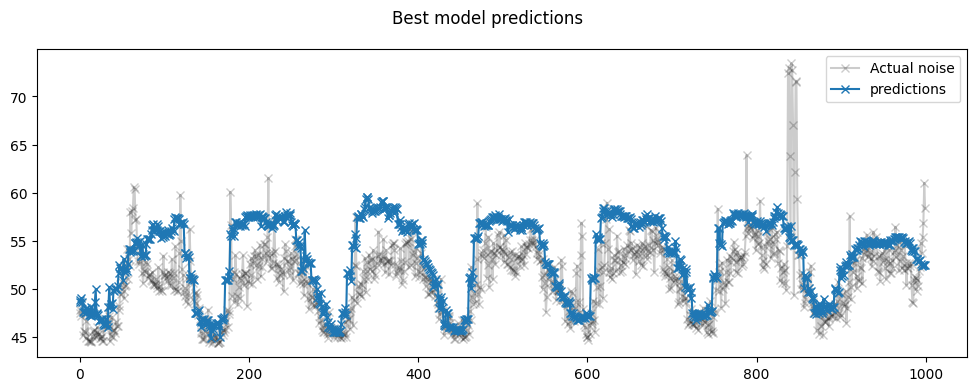

In [126]:
#visualization of model predictions, trained on full data

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Best model predictions")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(best_model_predictions[last_hours], "x-", label="predictions")
_ = ax.legend()


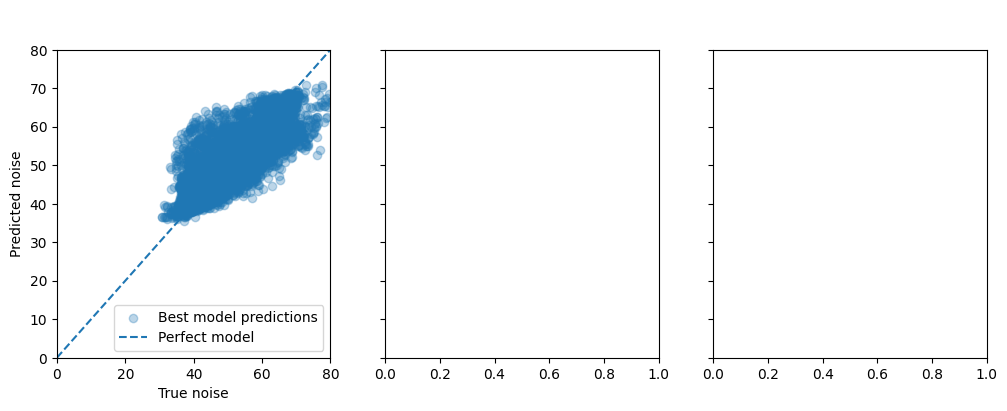

In [127]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle(" ")
predictions = [
    best_model_predictions,
]
labels = [
    "Best model predictions",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y_test.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

Shapley values

Add timestamp to predictions

In [128]:
delayed_df_test_timestamp = pd.DataFrame(delayed_df_test['result_timestamp'])
delayed_df_test_timestamp = delayed_df_test_timestamp.reset_index()
best_model_predictions = pd.DataFrame(best_model_predictions, columns=['predictions'])
best_model_predictions = best_model_predictions.reset_index()
predictions_timestamped = pd.concat([delayed_df_test_timestamp, best_model_predictions], axis = 1)


In [129]:
print(delayed_df_test_timestamp)

         index    result_timestamp
0            0 2022-04-06 17:40:00
1            1 2022-04-06 17:50:00
2            2 2022-04-06 17:50:00
3            3 2022-04-06 17:50:00
4            4 2022-04-06 18:00:00
...        ...                 ...
106536  106687 2022-12-31 23:10:00
106537  106688 2022-12-31 23:20:00
106538  106689 2022-12-31 23:30:00
106539  106690 2022-12-31 23:40:00
106540  106691 2022-12-31 23:50:00

[106541 rows x 2 columns]


In [130]:
print(len(best_model_predictions))
print(len(delayed_df_test['result_timestamp']))
print(len(predictions_timestamped['result_timestamp']))

106541
106541
106541


In [131]:
predictions_timestamped.isna().sum()

index               0
result_timestamp    0
index               0
predictions         0
dtype: int64

In [132]:
predictions_timestamped

,index,result_timestamp,index,predictions
0,0,2022-04-06 17:40:00,0,56.257969
1,1,2022-04-06 17:50:00,1,54.964897
2,2,2022-04-06 17:50:00,2,55.343533
3,3,2022-04-06 17:50:00,3,56.624657
4,4,2022-04-06 18:00:00,4,55.381210
...,...,...,...,...
106536,106687,2022-12-31 23:10:00,106536,52.412140
106537,106688,2022-12-31 23:20:00,106537,52.496964
106538,106689,2022-12-31 23:30:00,106538,52.513515
106539,106690,2022-12-31 23:40:00,106539,52.466835


In [133]:
predictions_timestamped = predictions_timestamped.drop('index',axis=1)

In [134]:
predictions_timestamped

,result_timestamp,predictions
0,2022-04-06 17:40:00,56.257969
1,2022-04-06 17:50:00,54.964897
2,2022-04-06 17:50:00,55.343533
3,2022-04-06 17:50:00,56.624657
4,2022-04-06 18:00:00,55.381210
...,...,...
106536,2022-12-31 23:10:00,52.412140
106537,2022-12-31 23:20:00,52.496964
106538,2022-12-31 23:30:00,52.513515
106539,2022-12-31 23:40:00,52.466835


In [135]:
predictions_timestamped.to_csv('predictions_timestamped.csv', index=False)